Use this code to generate synthetic data for Lutein production. The inputs of the data-driven model would be concentration of biomass (C_X) in the reactor, concentration of nitrate (C_N) in the reactor, concentration of Lutein (C_L) in the reactor, influx of nitrate (F_in), inlet nitrate concentration (C_N_in), light intensity (I0), and time t hours. The output should be C_X, C_N, and C_L at t+1 hours. 

In [1]:
# Following are parameters of the model mostly taken from https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.15667 but changed slightly (after unit conversion)
# Do not change this... 

u_m = 0.152 # 1/h
u_d = 5.95*1e-3 # 1/h
K_N = 30.0*1e-3 # g/L

Y_NX = 0.305 # g/g

k_m = 0.350*1e-3*2 #g/g-h

k_d = 3.71*0.05/90 # L/g-h

K_NL = 10.0*1e-3 # g/L

k_s = 142.8 # umol/m2-s

k_i = 214.2 # umol/m2-s

k_sL = 320.6 # umol/m2-s

k_iL = 480.9 # umol/m2-s

tau = 0.120 #m2/g

Ka = 0.0 #1/m

## Combinations using Itertools

In [10]:
import itertools
import numpy as np

#To generate data, just change these values in this block (perhaps in a loop), In my opinion, 
#a good range for C_x0 (which is the initial concnentration of biomass in the reactor C_X) is 0.2 - 2 g/L
# a good range for C_N0 (which is the initial concnetraiton of nitrate in the reactor C_N) is 0.2 - 2 g/L
# a good range for F_in (the inlet flow rate of nitrate into the reactor) is 1e-3 1.5e-2 L/h
# a good range for C_N_in (the inlet concentration of nitrate feed to the reactor) is 5 - 15 g/L
# a good range for intensity of light is 100 - 200 umol/m2-s

num_values = 4
#Create array of test values for each variable
C_x0_r = np.linspace(0.2, 2, num_values) #g/L
C_N0_r = np.linspace(0.2, 2, num_values) #g/L
F_in_r = np.linspace(1e-3, 1.5e-2, num_values) #L/h
C_N_in_r = np.linspace(5, 15, num_values) #g/L
I0_r = np.linspace(100, 200, num_values) # umol/m2-s

synth_data = []

synth_data = list(itertools.product(C_x0_r, C_N0_r, F_in_r, C_N_in_r, I0_r))

# Print the combinations
for combination in synth_data:
    print(combination)

(0.2, 0.2, 0.001, 5.0, 100.0)
(0.2, 0.2, 0.001, 5.0, 133.33333333333334)
(0.2, 0.2, 0.001, 5.0, 166.66666666666669)
(0.2, 0.2, 0.001, 5.0, 200.0)
(0.2, 0.2, 0.001, 8.333333333333334, 100.0)
(0.2, 0.2, 0.001, 8.333333333333334, 133.33333333333334)
(0.2, 0.2, 0.001, 8.333333333333334, 166.66666666666669)
(0.2, 0.2, 0.001, 8.333333333333334, 200.0)
(0.2, 0.2, 0.001, 11.666666666666668, 100.0)
(0.2, 0.2, 0.001, 11.666666666666668, 133.33333333333334)
(0.2, 0.2, 0.001, 11.666666666666668, 166.66666666666669)
(0.2, 0.2, 0.001, 11.666666666666668, 200.0)
(0.2, 0.2, 0.001, 15.0, 100.0)
(0.2, 0.2, 0.001, 15.0, 133.33333333333334)
(0.2, 0.2, 0.001, 15.0, 166.66666666666669)
(0.2, 0.2, 0.001, 15.0, 200.0)
(0.2, 0.2, 0.005666666666666666, 5.0, 100.0)
(0.2, 0.2, 0.005666666666666666, 5.0, 133.33333333333334)
(0.2, 0.2, 0.005666666666666666, 5.0, 166.66666666666669)
(0.2, 0.2, 0.005666666666666666, 5.0, 200.0)
(0.2, 0.2, 0.005666666666666666, 8.333333333333334, 100.0)
(0.2, 0.2, 0.005666666666666666

In [11]:
len(synth_data)

1024

The code below formulates and solves the ODE model in the paper https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.15667

We specifically use equations 1, 2, and 3. We approximate 3 for some intermediate value of Z to avoid using the averaging shown in equation 4. 

In [12]:
def pbr(t,C): # returns the RHS of the ODE model
    C_X = C[0] # concentration of biomass
    C_N = C[1] # concentration of nitrate
    C_L = C[2] # concentration of lutein
    
    I = 2*I0*(np.exp(-(tau*0.01*1000*C_X))) # computing attenuated intensity within the reactor. 
    
    Iscaling_u = I/(I+k_s + I**2/k_i)
    Iscaling_k = I/(I + k_sL + I**2/k_iL)
    
    u0 = u_m*Iscaling_u
    k0 = k_m*Iscaling_k
    
        
    #print(u_m, k_m, u0, k0,u_d)
    

    
    dCxdt = u0*C_N*C_X/(C_N + K_N) - u_d*C_X
    
    #print(C_N, C_X, (C_N + K_N), dCxdt, C_N*C_X/(C_N + K_N), u_d*C_X, C_N/(C_N + K_N))
    
    dCndt = -Y_NX*u0*C_N*C_X/(C_N + K_N) + F_in * C_N_in
    
    dCldt = k0*C_N*C_X/(C_N + K_NL) - k_d*C_L*C_X
    
    #print(k0, k_d, k0/k_d )
    
    return np.array([dCxdt, dCndt, dCldt])

In [13]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

mainData = pd.DataFrame()
for i, data in enumerate(synth_data):
    C_x0, C_N0, F_in, C_N_in, I0 = data
    
    ta = np.linspace(0,150,200)
    
   
    y = solve_ivp(pbr, [0, 150], np.array([C_x0, C_N0, 0.0]), t_eval=ta) # solves the ODE model for a given set of initial conditions and simulation time
    

    t = y.t
    C = y.y
    #print(C[2]*1000)
    save = pd.DataFrame()
    save['Time'] = t
    save['C_X'] = C[0]
    save['C_N'] = C[1]
    save['C_L'] = C[2]
    save['C_x0'] = C_x0
    save['C_N0'] = C_N0
    save['F_in'] = F_in
    save['C_N_in'] = C_N_in
    save['I0'] = I0
    save['Index'] = i
    mainData = pd.concat([mainData, save])

#from pathlib import Path  

#filepath = Path('Documents\STEMVisualsSynthData_Opt.csv')  

#filepath.parent.mkdir(parents=True, exist_ok=True)  

#mainData.to_csv(filepath) 

In [14]:
mainData

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
0,0.000000,0.200000,0.200000,0.000000,0.2,0.2,0.001,5.0,100.0,0
1,0.753769,0.206758,0.201430,0.000030,0.2,0.2,0.001,5.0,100.0,0
2,1.507538,0.213746,0.202779,0.000062,0.2,0.2,0.001,5.0,100.0,0
3,2.261307,0.220972,0.204047,0.000094,0.2,0.2,0.001,5.0,100.0,0
4,3.015075,0.228439,0.205231,0.000127,0.2,0.2,0.001,5.0,100.0,0
...,...,...,...,...,...,...,...,...,...,...
195,146.984925,3.490712,33.772813,0.005313,2.0,2.0,0.015,15.0,200.0,1023
196,147.738693,3.491313,33.937453,0.005319,2.0,2.0,0.015,15.0,200.0,1023
197,148.492462,3.491903,34.102095,0.005324,2.0,2.0,0.015,15.0,200.0,1023
198,149.246231,3.492482,34.266739,0.005329,2.0,2.0,0.015,15.0,200.0,1023


## Optimized with Endpoint

In [15]:
endpoint_df = mainData[mainData["Time"] == 150]

In [16]:
endpoint_df

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
199,150.0,2.006485,0.027028,0.007875,0.2,0.2,0.001,5.000000,100.000000,0
199,150.0,2.015396,0.018132,0.009006,0.2,0.2,0.001,5.000000,133.333333,1
199,150.0,2.022522,0.013922,0.009932,0.2,0.2,0.001,5.000000,166.666667,2
199,150.0,2.029450,0.011501,0.010717,0.2,0.2,0.001,5.000000,200.000000,3
199,150.0,2.631922,0.251323,0.007353,0.2,0.2,0.001,8.333333,100.000000,4
...,...,...,...,...,...,...,...,...,...,...
199,150.0,3.492753,26.931601,0.005336,2.0,2.0,0.015,11.666667,200.000000,1019
199,150.0,2.906175,34.747109,0.004491,2.0,2.0,0.015,15.000000,100.000000,1020
199,150.0,3.149013,34.617952,0.004863,2.0,2.0,0.015,15.000000,133.333333,1021
199,150.0,3.338119,34.515835,0.005130,2.0,2.0,0.015,15.000000,166.666667,1022


In [17]:
endpoint_L_max = endpoint_df['C_L'].max()

In [18]:
endpoint_max_info = endpoint_df[endpoint_df['C_L'] == endpoint_L_max]

In [19]:
endpoint_max_info

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
199,150.0,2.02945,0.011501,0.010717,0.2,0.2,0.001,5.0,200.0,3


In [20]:
#find experiment number
end_opt_index = endpoint_max_info.iat[0, 9]
end_opt_index

3

## Plot Optimized With Endpoint

In [21]:
optEndData = mainData.loc[mainData["Index"] == end_opt_index]

In [22]:
optEndData

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
0,0.000000,0.200000,0.200000,0.000000,0.2,0.2,0.001,5.0,200.0,3
1,0.753769,0.206021,0.201655,0.000038,0.2,0.2,0.001,5.0,200.0,3
2,1.507538,0.212250,0.203238,0.000077,0.2,0.2,0.001,5.0,200.0,3
3,2.261307,0.218694,0.204747,0.000118,0.2,0.2,0.001,5.0,200.0,3
4,3.015075,0.225360,0.206178,0.000159,0.2,0.2,0.001,5.0,200.0,3
...,...,...,...,...,...,...,...,...,...,...
195,146.984925,2.016566,0.011424,0.010627,0.2,0.2,0.001,5.0,200.0,3
196,147.738693,2.019799,0.011446,0.010649,0.2,0.2,0.001,5.0,200.0,3
197,148.492462,2.023029,0.011465,0.010672,0.2,0.2,0.001,5.0,200.0,3
198,149.246231,2.026248,0.011482,0.010695,0.2,0.2,0.001,5.0,200.0,3


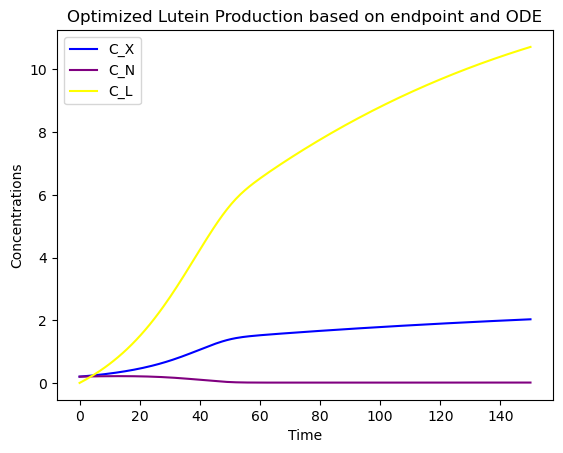

In [23]:
import matplotlib.pyplot as plt

plt.plot(optEndData['Time'], optEndData['C_X'], label = "C_X", color = 'blue')
plt.plot(optEndData['Time'], optEndData['C_N'], label = "C_N", color = 'purple')
plt.plot(optEndData['Time'], (optEndData['C_L'] * 1000), label = "C_L", color = 'yellow')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')
plt.title("Optimized Lutein Production based on endpoint and ODE")
plt.show()

0.008309
0.007762

## Optimized with Max Lutein 

In [ ]:
abs_L_max = mainData['C_L'].max()

In [ ]:
abs_max_info = mainData[mainData['C_L'] == abs_L_max]

In [ ]:
abs_max_info

In [ ]:
#find experiment number
abs_opt_index = abs_max_info.iat[0, 9]
abs_opt_index

## Plot Absolute Max Lutein

In [ ]:
abs_optData = mainData.loc[mainData["Index"] == abs_opt_index]

In [ ]:
abs_optData

In [ ]:
import matplotlib.pyplot as plt

plt.plot(abs_optData['Time'], abs_optData['C_X'], label = "C_X", color = 'blue')
plt.plot(abs_optData['Time'], abs_optData['C_N'], label = "C_N", color = 'purple')
plt.plot(abs_optData['Time'], (abs_optData['C_L'] * 1000), label = "C_L", color = 'yellow')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')
plt.title("Optimized Lutein Production based absolute max and on ODE")
plt.show()

## Cost/Benefit Analysis

In [ ]:
#conc of N at endpoint
#light intensity may changes, does that change the cost?
#Biomass value
#Lutein Value

In [24]:
#Define Variables

N_cost = (68.80/500) # $/g
L_value = (645/300) # $/mg
X_value = 815 # $/ton
#Light_cost
#CO2 constant

#change units

L_value = L_value * 1000 # (mg --> g)
X_value = X_value / 907185 # ton --> gram

In [36]:
cost_endpoint_df = endpoint_df
cost_endpoint_df

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index,Nitrate Cost,Lutein Value,Biomass Value,Profit
199,150.0,2.006485,0.027028,0.007875,0.2,0.2,0.001,5.000000,100.000000,0,0.003719,16.930239,0.000007,16.926527
199,150.0,2.015396,0.018132,0.009006,0.2,0.2,0.001,5.000000,133.333333,1,0.002495,19.362810,0.000008,19.360324
199,150.0,2.022522,0.013922,0.009932,0.2,0.2,0.001,5.000000,166.666667,2,0.001916,21.353303,0.000009,21.351396
199,150.0,2.029450,0.011501,0.010717,0.2,0.2,0.001,5.000000,200.000000,3,0.001582,23.041315,0.000010,23.039742
199,150.0,2.631922,0.251323,0.007353,0.2,0.2,0.001,8.333333,100.000000,4,0.034582,15.808175,0.000007,15.773599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,150.0,3.492753,26.931601,0.005336,2.0,2.0,0.015,11.666667,200.000000,1019,3.705788,11.472286,0.000005,7.766502
199,150.0,2.906175,34.747109,0.004491,2.0,2.0,0.015,15.000000,100.000000,1020,4.781202,9.655910,0.000004,4.874712
199,150.0,3.149013,34.617952,0.004863,2.0,2.0,0.015,15.000000,133.333333,1021,4.763430,10.456059,0.000004,5.692633
199,150.0,3.338119,34.515835,0.005130,2.0,2.0,0.015,15.000000,166.666667,1022,4.749379,11.029300,0.000005,6.279926


In [31]:
cost_endpoint_df['Nitrate Cost'] = (cost_endpoint_df["C_N"] * N_cost) # not sure the volume of the reactor to get grams by itself (calucating off g/L)
cost_endpoint_df["Lutein Value"] = (cost_endpoint_df["C_L"] * L_value)
cost_endpoint_df["Biomass Value"] = (cost_endpoint_df["C_L"] * X_value)

/var/folders/h4/rk3ndbz5153bv6t75m30mlb00000gn/T/ipykernel_23960/2675636400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endpoint_df['Nitrate Cost'] = (endpoint_df["C_N"] * N_cost) # not sure the volume of the reactor to get grams by itself (calucating off g/L)
/var/folders/h4/rk3ndbz5153bv6t75m30mlb00000gn/T/ipykernel_23960/2675636400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endpoint_df["Lutein Value"] = (endpoint_df["C_L"] * L_value)
/var/folders/h4/rk3ndbz5153bv6t75m30mlb00000gn/T/ipyke

In [32]:
cost_endpoint_df

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index,Nitrate Cost,Lutein Value,Biomass Value
199,150.0,2.006485,0.027028,0.007875,0.2,0.2,0.001,5.000000,100.000000,0,0.003719,16.930239,0.000007
199,150.0,2.015396,0.018132,0.009006,0.2,0.2,0.001,5.000000,133.333333,1,0.002495,19.362810,0.000008
199,150.0,2.022522,0.013922,0.009932,0.2,0.2,0.001,5.000000,166.666667,2,0.001916,21.353303,0.000009
199,150.0,2.029450,0.011501,0.010717,0.2,0.2,0.001,5.000000,200.000000,3,0.001582,23.041315,0.000010
199,150.0,2.631922,0.251323,0.007353,0.2,0.2,0.001,8.333333,100.000000,4,0.034582,15.808175,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,150.0,3.492753,26.931601,0.005336,2.0,2.0,0.015,11.666667,200.000000,1019,3.705788,11.472286,0.000005
199,150.0,2.906175,34.747109,0.004491,2.0,2.0,0.015,15.000000,100.000000,1020,4.781202,9.655910,0.000004
199,150.0,3.149013,34.617952,0.004863,2.0,2.0,0.015,15.000000,133.333333,1021,4.763430,10.456059,0.000004
199,150.0,3.338119,34.515835,0.005130,2.0,2.0,0.015,15.000000,166.666667,1022,4.749379,11.029300,0.000005


In [33]:
cost_endpoint_df['Profit'] = ((cost_endpoint_df['Lutein Value'] + cost_endpoint_df["Biomass Value"]) - cost_endpoint_df['Nitrate Cost'])

/var/folders/h4/rk3ndbz5153bv6t75m30mlb00000gn/T/ipykernel_23960/3796600718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endpoint_df['Profit'] = ((endpoint_df['Lutein Value'] + endpoint_df["Biomass Value"]) - endpoint_df['Nitrate Cost'])


In [34]:
cost_endpoint_df

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index,Nitrate Cost,Lutein Value,Biomass Value,Profit
199,150.0,2.006485,0.027028,0.007875,0.2,0.2,0.001,5.000000,100.000000,0,0.003719,16.930239,0.000007,16.926527
199,150.0,2.015396,0.018132,0.009006,0.2,0.2,0.001,5.000000,133.333333,1,0.002495,19.362810,0.000008,19.360324
199,150.0,2.022522,0.013922,0.009932,0.2,0.2,0.001,5.000000,166.666667,2,0.001916,21.353303,0.000009,21.351396
199,150.0,2.029450,0.011501,0.010717,0.2,0.2,0.001,5.000000,200.000000,3,0.001582,23.041315,0.000010,23.039742
199,150.0,2.631922,0.251323,0.007353,0.2,0.2,0.001,8.333333,100.000000,4,0.034582,15.808175,0.000007,15.773599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,150.0,3.492753,26.931601,0.005336,2.0,2.0,0.015,11.666667,200.000000,1019,3.705788,11.472286,0.000005,7.766502
199,150.0,2.906175,34.747109,0.004491,2.0,2.0,0.015,15.000000,100.000000,1020,4.781202,9.655910,0.000004,4.874712
199,150.0,3.149013,34.617952,0.004863,2.0,2.0,0.015,15.000000,133.333333,1021,4.763430,10.456059,0.000004,5.692633
199,150.0,3.338119,34.515835,0.005130,2.0,2.0,0.015,15.000000,166.666667,1022,4.749379,11.029300,0.000005,6.279926


In [37]:
endpoint_cost_max = cost_endpoint_df['Profit'].max()

In [40]:
cost_max_info = cost_endpoint_df[cost_endpoint_df['Profit'] == endpoint_cost_max]

In [41]:
cost_max_info

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index,Nitrate Cost,Lutein Value,Biomass Value,Profit
199,150.0,2.02945,0.011501,0.010717,0.2,0.2,0.001,5.0,200.0,3,0.001582,23.041315,0.00001,23.039742


In [42]:
#find experiment number
cost_opt_index = cost_max_info.iat[0, 9]
cost_opt_index

3

In [43]:
optCostData = mainData.loc[mainData["Index"] == end_opt_index]
optCostData

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
0,0.000000,0.200000,0.200000,0.000000,0.2,0.2,0.001,5.0,200.0,3
1,0.753769,0.206021,0.201655,0.000038,0.2,0.2,0.001,5.0,200.0,3
2,1.507538,0.212250,0.203238,0.000077,0.2,0.2,0.001,5.0,200.0,3
3,2.261307,0.218694,0.204747,0.000118,0.2,0.2,0.001,5.0,200.0,3
4,3.015075,0.225360,0.206178,0.000159,0.2,0.2,0.001,5.0,200.0,3
...,...,...,...,...,...,...,...,...,...,...
195,146.984925,2.016566,0.011424,0.010627,0.2,0.2,0.001,5.0,200.0,3
196,147.738693,2.019799,0.011446,0.010649,0.2,0.2,0.001,5.0,200.0,3
197,148.492462,2.023029,0.011465,0.010672,0.2,0.2,0.001,5.0,200.0,3
198,149.246231,2.026248,0.011482,0.010695,0.2,0.2,0.001,5.0,200.0,3


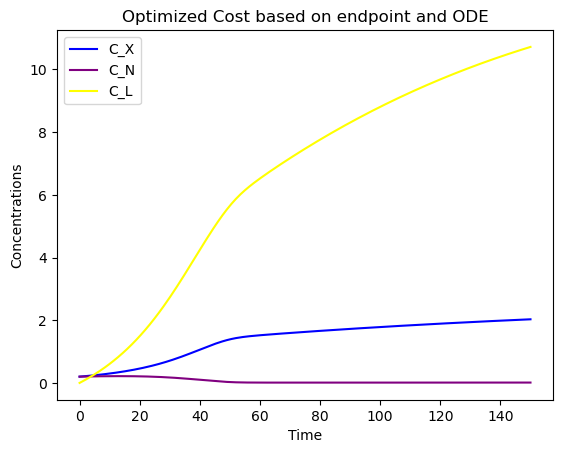

In [44]:
import matplotlib.pyplot as plt

plt.plot(optEndData['Time'], optEndData['C_X'], label = "C_X", color = 'blue')
plt.plot(optEndData['Time'], optEndData['C_N'], label = "C_N", color = 'purple')
plt.plot(optEndData['Time'], (optEndData['C_L'] * 1000), label = "C_L", color = 'yellow')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')
plt.title("Optimized Cost based on endpoint and ODE")
plt.show()